In [10]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

In [11]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [12]:
load_dotenv(override=True)

True

Use **Annotated** to add extra information to the type. Example:

```python
my_favourite_things: Annotated[List, "these are a few of mine"]
# my_favourite_things: List
```

LangGraph need this feature when define State object, bacause it want us to tell what function it should call to update the State with a new value. 

This function is called a **Reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case

### Step 1: Define the State object

We can use any python object, but it's most common to use a **TypeDict** or a **Pydantic BaseModel**

In [13]:
class State(BaseModel):
    messages: Annotated[list, add_messages] # reducer: add_messages

### Step 2: Start the Graph Builder with this State class

In [14]:
graph_builder = StateGraph(State)

### Step 3: Create a Node

A node can be any Python function

The reducer that we set before gets automatically called to combine this response with previous responses

In [15]:
def first_node(old_state: State) -> State:
    reply = f'{random.choice(nouns)} are {random.choice(adjectives)}'
    messages = [{'role': 'assistant', 'content': reply}]
    new_state = State(messages=messages)
    return new_state

graph_builder.add_node('first_node', first_node)

### Step 4: Create Edges

In [16]:
graph_builder.add_edge(START, 'first_node')
graph_builder.add_edge('first_node', END)

### Step 5: Compile the graph

In [18]:
graph = graph_builder.compile()

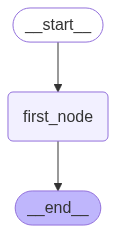

In [22]:
display(Image(
    graph.get_graph().draw_mermaid_png()
))

In [23]:
def chat(user_input: str, history):
    message = {'role': 'user', 'content': user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result['messages'][-1].content

In [ ]:
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi there', additional_kwargs={}, response_metadata={}, id='3880758d-9427-4177-8577-9b9de96d3d11'), AIMessage(content='Penguins are haunted', additional_kwargs={}, response_metadata={}, id='bf726de5-3d20-4de4-a392-6228e4764f43')]}
{'messages': [HumanMessage(content='is that so?', additional_kwargs={}, response_metadata={}, id='17a6793d-36a3-4fc1-8c03-d4d77bf01e1b'), AIMessage(content='Penguins are moody', additional_kwargs={}, response_metadata={}, id='b4286910-229b-4c4a-b9f7-e36f377619b8')]}


Above example is just to make the point that LangGraph is all about Python function, doesn't need to involve LLMs

In [25]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]

In [27]:
# Step 2: Start the Graph builder with this State class
graph_builder = StateGraph(State)

In [ ]:
# Step 3: Create a Node

llm = ChatOpenAI(model_name='gpt-4o-mini', temperature=0.7)

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node('chatbot_node', chatbot_node)

In [36]:
# Step 4: Create edges
graph_builder.add_edge(START, 'chatbot_node')
graph_builder.add_edge('chatbot_node', END)


Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.
Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


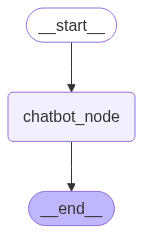

In [37]:
# Step 5: Compile the Graph
graph = graph_builder.compile()

# Display graph
display(Image(
    graph.get_graph().draw_mermaid_png()
))


In [38]:
def chat(user_input: str, history):
    initial_state = State(messages=[{'role': 'user', 'content': user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content

In [ ]:
gr.ChatInterface(chat, type='messages').launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='Hi my name is Anh', additional_kwargs={}, response_metadata={}, id='83dbbff4-9331-4f8f-a2f8-2d765d3f23d7'), AIMessage(content='Hi Anh! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bf1B5pzZ5D8KP35BJFlFoMP7tN35g', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8574862c-cc59-4fe0-9aae-4651a78e2198-0', usage_metadata={'input_tokens': 12, 'output_tokens': 10, 'total_tokens': 22, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
{'messages': [Human